In [1]:
import IPython.core.display
import matplotlib

def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1

apply_styles()

In [2]:
%%html
<style type="text/css">
@import url('https://fonts.googleapis.com/css?family=Playfair+Display');


div.text_cell_render {font-family: 'Playfair Display', serif; color: #13213b; line-height: 145%; font-size:16px;}
</style>

<span style="color:#13213b;">[Andrii Gakhov](https://www.gakhov.com) / PyCon UA 2018</span>
* * *
## An Introduction to Time Series Forecasting with Python
Time series is an important instrument to model, analyze and predict data collected over time. In this talk, we learn the basic theoretical concepts without going deep into mathematical aspects, study different models, and try them in practice using StatsModels, Prophet, scikit-learn, and keras.

# Part 1. Look into the data
******

### OS visits to UK (All visits) 
The dataset represents the monthly total number of visits to the UK by overseas residents (in thousands)<br>from January 1980 to October 2017. 

#### Source: [Office for National Statistics](https://www.ons.gov.uk/peoplepopulationandcommunity/leisureandtourism/timeseries/gmaa/ott)

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")

In [4]:
import warnings
warnings.filterwarnings('ignore')

### Load the data into Pandas DataFrame

In [5]:
import pandas as pd
df = pd.read_csv("data/GMAA-040218.csv", header=None, skiprows=6, parse_dates=[0], names=['period', 'value'])
df.value.astype(int, copy=False);

In [6]:
df.head(5)

,period,value
0,1980-01-01,739
1,1980-02-01,602
2,1980-03-01,740
3,1980-04-01,1028
4,1980-05-01,1088


In [7]:
max_date = df.period.max()
min_date = df.period.min()

num_of_actual_points = df.index.shape[0]
num_of_expected_points = (max_date.year - min_date.year) * 12 + max_date.month - min_date.month + 1

print("Date range: {} - {}".format(min_date.strftime("%d.%m.%Y"), max_date.strftime("%d.%m.%Y")))
print("Number of data points: {} of expected {}".format(num_of_actual_points, num_of_expected_points))


Date range: 01.01.1980 - 01.10.2017
Number of data points: 454 of expected 454


### Visualize the data

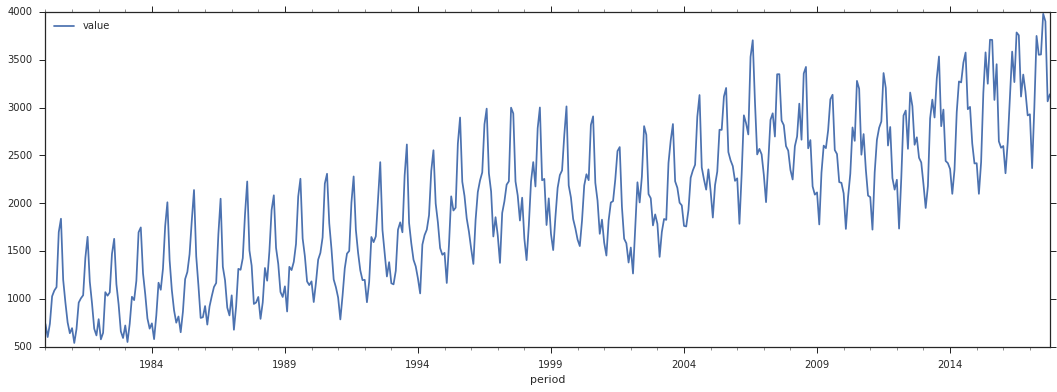

In [8]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="period", y="value", ax=ax)
plt.legend(loc='upper left')

plt.savefig('images/intro-visualization.png');

In **2001** a combination of the outbreak of foot and mouth disease and the September 11 attacks in the US led to a dramatic slump.

In **2009** the global economic crisis, which started to bite in earnest in the autumn, was blamed as a factor for the fall. 

https://www.theguardian.com/business/2009/jul/16/tourism-uk-visitors-fall

In 2006 total visits to the UK by overseas residents were split fairly
equally between three purposes: holiday, visiting friends or relatives,
and business. This pattern is quite different compared with ten years
ago, when ‘holiday’ was the dominant reason

https://www.ons.gov.uk/ons/rel/ott/travel-trends/2006/travel-trends---2006.pdf

The majority of visitors were from North America, followed by tourists from France and Germany.
http://www.bbc.com/news/uk-england-london-27323755

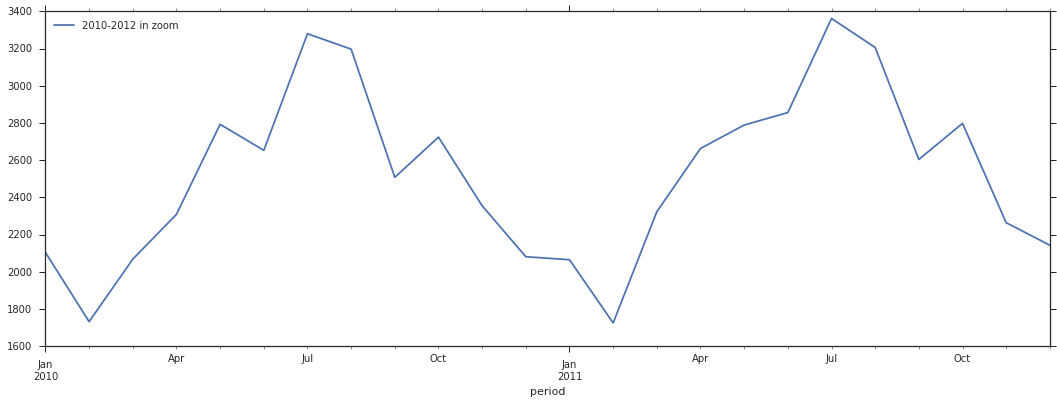

In [9]:
zoom_range = df[(df.period >= '2010-01-01') & (df.period < '2012-01-01')].index

fig, ax = plt.subplots(figsize=(18,6))
df.loc[zoom_range].plot(x="period", y="value", ax=ax, label="2010-2012 in zoom")
plt.legend(loc='upper left')

plt.savefig('images/intro-zoom.png');

#### When is the best time to visit the UK?

The United Kingdom can be visited at any time of year ... Overall, **spring (late March to early June) and autumn (September to November) are the best times to visit**, when it’s usually warm and dry.

https://www.audleytravel.com/us/uk/best-time-to-visit

## Trend and seasonality

From the visualization it's already quite obvious that the OS visits have periodic fluctuations each year and overall tendency to grow up.

Thus, we can conclude that the time series has the **trend** and yearly **seasonality** components, and we can try to decompose them them using, for instance, **statsmodels** package.

Note, from the data view we also can suspect that **additive** model better fits for data representation.

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompfreq = 12  # 12 months seasonality
model = 'additive'

decomposition = seasonal_decompose(
    df.set_index("period").value.interpolate("linear"),
    freq=decompfreq,
    model=model)

In [11]:
trend = decomposition.trend
seasonal = decomposition.seasonal 
residual = decomposition.resid 

### The Trend

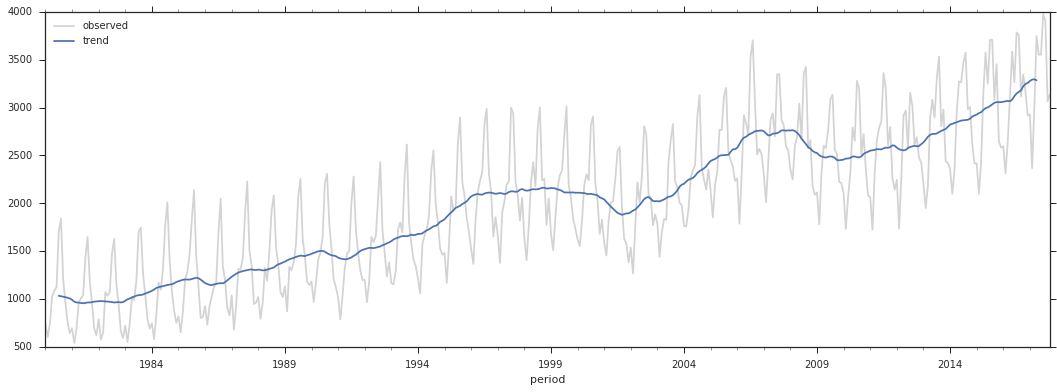

In [12]:
fig, ax = plt.subplots(figsize=(18,6))
df.plot(x="period", y="value", ax=ax, label="observed", c='lightgrey')
trend.plot(ax=ax, label="trend")
plt.legend(loc='upper left')

plt.savefig('images/intro-trend.png');

### The Seasonality

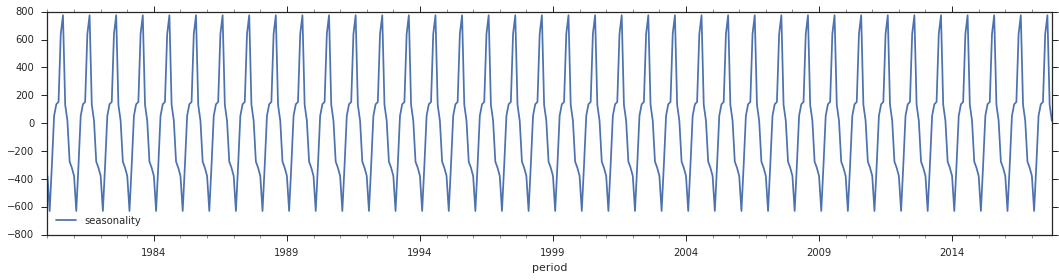

In [13]:
fig, ax = plt.subplots(figsize=(18,4))
seasonal.plot(ax=ax, label="seasonality")
plt.legend(loc='bottom left')

plt.savefig('images/intro-seasonality.png');

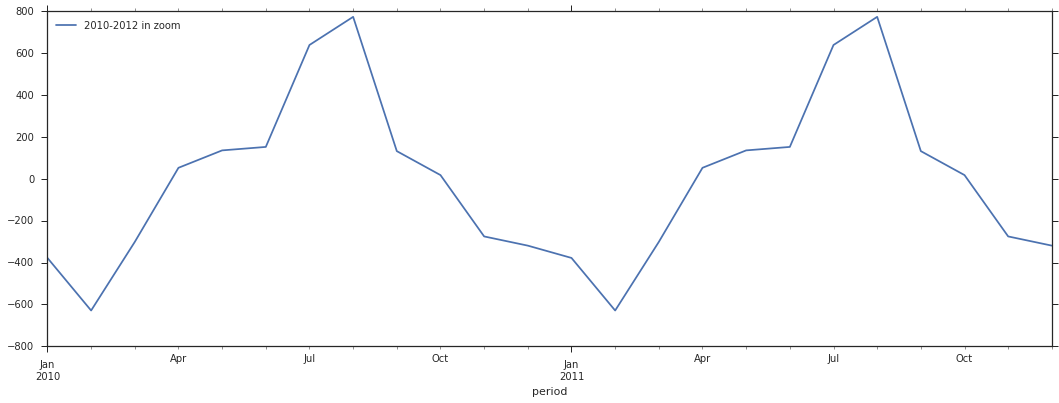

In [14]:
fig, ax = plt.subplots(figsize=(18,6))
seasonal[zoom_range].plot(x="period", y="value", ax=ax, label="2010-2012 in zoom")
plt.legend(loc='upper left')

plt.savefig('images/intro-seasonality-zoom.png');

### The Residual

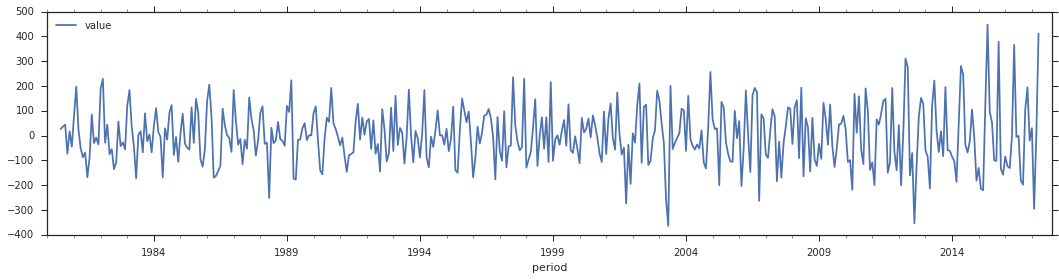

In [15]:
fig, ax = plt.subplots(figsize=(18,4))
residual.plot(ax=ax, legend="seasonality")
plt.legend(loc='upper left')

plt.savefig('images/intro-residual.png');